# Logistic回归

**一般流程**

---
1. 收集数据
2. 准备数据：因为要进行距离计算，因此要求数据为数值型，另外结构化数据格式最佳
3. 分析数据
4. 训练算法：找到最佳的分类回归系数
5. 测试算法
6. 使用算法：给定一部分输入，并将其格式转化，基于训练好的回归系数进行简单的回归计算，判断其所属类别

---
- 优点: 计算代价不高，易于理解和实现
- 缺点：容易欠拟合，分类精度可能不足
- 使用数据类型：数值型和标称型
---

## 理论基础

我们需要函数能接受所有的输入然后预测出类别，这类函数称为Heaviside step function或单位阶跃函数，而sigmoid/logistic函数可以提供相似的功能，且sigmoid有更多优势，sigmoid如下,**W**是待调整参数
$$
\sigma(z) = \frac 1 {1+e^{-z}} \\
z = w_0x_0 + w_1x_1 + \cdots + w_nx_n = W^TX
$$

依据sigmoid函数的特性，做出如下假设
$$
p(y=1|x,\theta) = h_{\theta}(x)\\
p(y=0|x,\theta) = 1 - h_{\theta}(x)\\
$$
理论上来说各点概率为1效果最好，合并上述两个公式为代价函数 $ cost(h_\theta(x),y) = h_\theta(x)^y(1-h_\theta(x))^{1-y}$

为了简化对其求对数,于是代价函数为 $cost(h_\theta(x),y) =y log(h_\theta(x))+(1-y)log(1-h_\theta(x))$

假设样本之间相互独立，使用**极大似然估计法**，整个样本集合产生的概率为所有样本生成概率的乘积，再将其对数化:
$$
J(\theta) = \sum^m_{i=1}{cost(h_\theta(x^i),y^i)}
$$
故由极大似然估计可知，使得$J(\theta)$为最大的$\theta$即为估计值


# 基于最优化方法获取最佳回归系数
## 批次梯度上升法
$$
\nabla f(x,y) = 
    \begin{pmatrix}
        \frac{\partial f(x,y)}{\delta x} \\
        \frac{\partial f(x,y)}{\delta y} \\
    \end{pmatrix}
    \\
    w:= w+\alpha \nabla_w f(w)
$$
- w将会被一直迭代知道达到某个停止条件，由于每次迭代w的移动方向都是当前位置上使得目标函数改变最大的方向，因此叫做梯度上升法
- 梯度下降法阈值相对应，只不过加法换成减法。另外梯度上升求解最大值，梯度下降通常用来求解最小值

由理论基础知,链式法则得
$$
\frac{\partial cost(\theta)}{\partial \theta_j} = \frac{\partial cost(\theta)}{\partial h(z)}*
\frac{\partial h(z)}{\partial z}*\frac{\partial z}{\partial \theta_j}\\
= \{y\frac{1}{h(z)} + (y-1)\frac{1}{1-h(z)}\} * \{{h(z)(1-h(z))}\} * {x_j}\\
= (y-h(z))x_j
$$

### 训练算法


In [1]:
import numpy as np
def loadDataSet():
    dataMat = []
    labelMat = []
    fr = open('../data/LogisticRegression/testSet.txt')
    for line in fr.readlines():
        lineArr = line.strip().split()
        dataMat.append([1.0,float(lineArr[0]),float(lineArr[1])])
        labelMat.append(int(lineArr[2]))
    return dataMat,labelMat

def sigmoid(inX):
    return 1.0/(1+np.exp(-inX))

def gradAscent(dataMatIn,classLabels):
    dataMatrix = np.matrix(dataMatIn)
    labelMat = np.matrix(classLabels).transpose()
    m,n = dataMatrix.shape
    # 步长
    alpha = 0.001 
    maxCycles = 500
    weights = np.matrix(np.ones((n,1)))
    for k in range(maxCycles):
        h = sigmoid(dataMatrix*weights)
        error = (labelMat-h)
        weights += alpha * dataMatrix.transpose()*error
    return weights

In [2]:
dataArr,labelMat = loadDataSet()
weights = gradAscent(dataArr,labelMat)
weights

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

### 分析数据：绘制决策边界

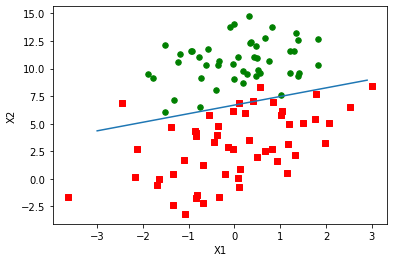

In [3]:
import matplotlib.pyplot as plt
def plotBestFit(weights):
    dataMat,labelMat = loadDataSet()
    dataArr = np.array(dataMat)
    n = dataArr.shape[0]
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i])==1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1,ycord1,s=30,c='red',marker='s')
    ax.scatter(xcord2,ycord2,s=30,c='green')


    # 由分界面0=w0x0 + w1x1 + w2x2 导出x2
    x1 = np.arange(-3.0,3.0,0.1)
    x2 = (-weights[0]-weights[1]*x1)/weights[2]
    ax.plot(x1,x2)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    
plotBestFit(weights.getA())

## 随机梯度上升法

- 批梯度上升法每次更新系数都要遍历数据集，如果数据和特征数量太多该方法计算复杂度会过高
- 可以通过随机梯度上升法来改进，每次仅用一个样本点更新参数
- 由于可以在新样本到来时对分类器进行增量更新，该算法是一个在线学习算法，与在线学习对应一次处理所有数据被称为‘批处理’
### e.g. 1

In [4]:
def stocGradAscent0(dataMatrix,classLabels):
    m,n = np.shape(dataMatrix)
    alpha = 0.01
    weights = np.ones(n)
    for i in range(m):
        # 这里是array所以需要使用sum而不是之前的矩阵转置相乘操作
        h = sigmoid(sum(dataMatrix[i]*weights))
        error = classLabels[i]-h
        weights = weights + alpha*error*dataMatrix[i]
    return weights

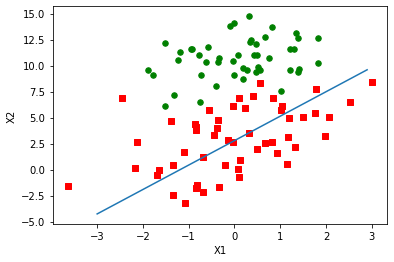

In [5]:
dataArr,labelMat = loadDataSet()
weights = stocGradAscent0(np.array(dataArr),labelMat)
plotBestFit(weights)

### e.g.2 
1. 步长**非严格下降**来进行优化
2. 随机选取样本来更新回归系数，可以减少周期性的波动
3. 这种方式收敛的更快

In [6]:
import random
# 改进随机梯度上升算法
def stocGradAscent1(dataMatrix,classLabels,numIter=150):
    m,n = np.shape(dataMatrix)
    weights = np.ones(n)
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m):
            # alpha动态调整，同时利用i，j也能避免参数严格下降
            alpha = 4/(1.0+j+i) +0.01
            # 随机选择样本进行梯度下降
            randIndex = int(random.uniform(0,len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex]-h
            weights = weights + alpha*error*dataMatrix[randIndex]
            del(dataIndex[randIndex])
            
    return weights

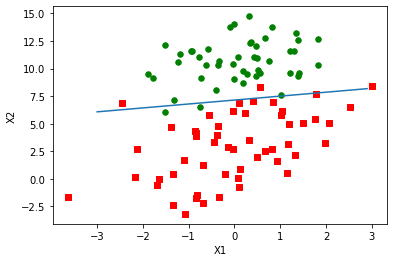

In [7]:
dataArr,labelMat = loadDataSet()
weights = stocGradAscent1(np.array(dataArr),labelMat)
plotBestFit(weights)

**显然在此使用了更少的迭代次数，且获得了与之前批梯度上升接近的效果**

# e.g. 从疝气病症预测病马死亡率
- 在此使用logistic回归预测疝病马的存活问题，数据包含368个样本和28个特征
- 该数据部分值班表比较主观，难以测量
- 数据集中有30%的缺失值

## 准备数据：处理数据中缺失值
1. 所有缺失值用一个实值来替换，此处选择使用0替换，这样在更新时缺失值不会影响系数
2. 由于sigmoid(0) = 0.5其对结果的预测不具有倾向性，因此这种补充也不会对误差造成影响
3. 由于数据中有效值大都不是0，因此其在某种意义上也满足‘特殊值的要求’
4. 对于缺失类别标签的数据，我们对其直接丢弃，因为标签数据通常很难对其进行填补

## 测试算法

In [8]:
#对sigmoid函数的优化，避免了出现极大的数据溢出
def sigmoid(inX):
    if inX>=0:      
        return 1.0/(1+np.exp(-inX))
    else:
        return np.exp(inX)/(1+np.exp(inX))

# 分类函数
def classifyVector(inX,weights):
    prob = sigmoid(sum(inX*weights))
    if prob > 0.5:
        return 1.0
    else:
        return 0.0
    
def colicTest():
    frTrain = open('../data/LogisticRegression/horseColicTraining.txt')
    frTest = open('../data/LogisticRegression/horseColicTest.txt')
    trainingSet = []
    trainingLabels = []
    for line in frTrain.readlines():
        currLine = line.strip().split('\t')
        lineArr = []
        # 添加特征
        for i in range(len(currLine)-1):
            lineArr.append(float(currLine[i]))
        trainingSet.append(lineArr)
        # 添加标签
        trainingLabels.append(float(currLine[-1]))

    # 训练权重weights
    trainWeights = stocGradAscent1(np.array(trainingSet),trainingLabels,500)

    # 测试
    errorCount = 0.0
    numTestVec = 0.0
    for line in frTest.readlines():
        numTestVec += 1.0
        currLine = line.strip().split('\t')
        lineArr = []
        for i in range(len(currLine)-1):
            lineArr.append(float(currLine[i]))
        if int(classifyVector(np.array(lineArr),trainWeights)) != int(currLine[-1]):
            errorCount += 1
    errorRate = float(errorCount)/numTestVec
    print('the error rate of this test is: %f'%errorRate)
    return errorRate

def multiTest():
    numTests = 10
    errorSum = 0.0
    for k in range(numTests):
        errorSum += colicTest()
    print('After %d iterations the average error rate is %f '%(numTests,errorSum/float(numTests)))

In [9]:
multiTest()

the error rate of this test is: 0.402985
the error rate of this test is: 0.328358
the error rate of this test is: 0.328358
the error rate of this test is: 0.373134
the error rate of this test is: 0.298507
the error rate of this test is: 0.328358
the error rate of this test is: 0.402985
the error rate of this test is: 0.507463
the error rate of this test is: 0.447761
the error rate of this test is: 0.328358
After 10 iterations the average error rate is 0.374627 


# Summary
- logistic回归的目的是寻找一个非线性函数Sigmoid的最佳拟合参数，且结果呈可以由最优化算法完成。
- 最优化算法中，常用的是梯度上升法，而梯度上升算法可以简化为随机梯度上升
- 随机梯度上升性能更优，而且并不需要读取整个数据集进行批运算
- 关于缺失数据的处理，没有标准答案，取决于实际应用中的需求